# El niño efects?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, Point
import os
import seaborn as sns
from shapely.ops import nearest_points

## cargue los datos

In [2]:
npfile   = np.load(r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\theilslopes_DTW.npz')

In [3]:
syr      = npfile.f.dtw_syr
condyr   = npfile.f.dtw_condyr
s_nmax_yr= npfile.f.dtw_s_nmax_yr
nmax_yr  = npfile.f.dtw_nmax_yr
vyr      = npfile.f.dtw_vyr
tyr      = npfile.f.dtw_tyr
lat      = npfile.f.lat
lon      = npfile.f.lon
interc_t = npfile.f.dtw_interc_t
slop_t   = npfile.f.dtw_slop_t

ndat = len(condyr)
ngood = np.count_nonzero(condyr==1)

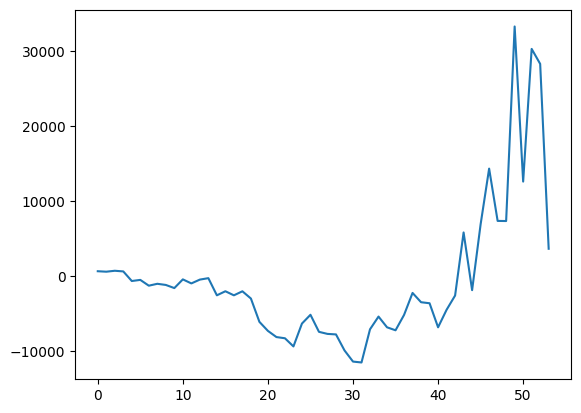

In [4]:
t_all = tyr[1,:]
tmin  = np.min(t_all)-1
tmax  = np.max(t_all)+1

vmat   = np.zeros((len(t_all),ngood))
vstack = np.zeros(len(t_all))
vstack[:] = np.nan
vmat[:]   = np.nan

ncnt = -1
for i in range(ndat):
    if (condyr[i]==0):
        continue
    ncnt = ncnt + 1
    # Puntos válidos
    #print(syr[i], condyr[i])
    #print(s_nmax_yr[i],nmax_yr[i])
    i0 = s_nmax_yr[i]
    i1 = i0+nmax_yr[i]
    t  = t_all[i0:i1]
    pline = t*slop_t[i] + interc_t[i]

    res   = vyr[i,i0:i1]-pline
    res = np.nan_to_num(res)
    vstack[i0:i1] = np.where(np.isnan(vstack[i0:i1]), res, vstack[i0:i1] + res)
    vmat[i0:i1,ncnt] = res

    continue
    
    fig = plt.figure()
    ax1 = fig.add_subplot(2,1,1)
    ax1.plot(t_all,vyr[i,:],'lightgray')
    ax1.plot(t,vyr[i,i0:i1],'k')
    ax1.plot(t,pline)
    ax1.set_xlim(tmin,tmax)
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(t,res) 
    ax2.plot(t_all,vstack,'lightgray')
    ax2.set_xlim(tmin,tmax)

fig = plt.figure()
plt.plot(t_all,vstack)
plt.show()

(-5.0, 5.0)

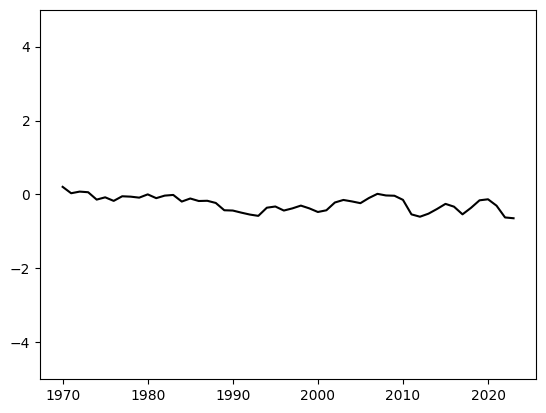

In [5]:
N = ngood
#plt.plot(vmat[:,0:N],'.')
plt.plot(t_all+1970,np.nanmedian(vmat[:,0:N],axis=1),'k-')
plt.ylim(-5,5)

#### Residuales: regiones geográficas

In [5]:
def asignar_region(lat, lon):
    """Devuelve el nombre de la región de Australia según lat/lon."""
    if lon > 129 and lon < 141 and lat < -25:  
        return "South Australia"
    elif lon > 129 and lat >= -25:  
        return "Northern Territory"
    elif lon > 138 and lat < -28:  
        return "Victoria"
    elif lon > 140 and lat < -26:  
        return "New South Wales"
    elif lon > 138 and lon < 154 and lat >= -28:  
        return "Queensland"
    elif lon > 112 and lon < 129:  
        return "Western Australia"
    elif lat < -39.2 and lon > 144 and lon < 149:  
        return "Tasmania"
    else:
        return "Unknown"

In [6]:
# Usar listas para acumular valores antes de convertir a matriz
residuales_por_region = defaultdict(list)

# Encontrar la longitud máxima de todas las series (para padding con NaN)
max_length = len(t_all)

for i in range(ndat):
    if condyr[i] == 0:
        continue

    region = asignar_region(lat[i], lon[i])  # Determinar la región de cada estación

    if region != "Unknown":
        i0, i1 = s_nmax_yr[i], s_nmax_yr[i] + nmax_yr[i]
        
        if i1 > max_length:  # Asegurar que no exceda el índice
            i1 = max_length

        res = vyr[i, i0:i1] - (t_all[i0:i1] * slop_t[i] + interc_t[i])
        res = np.nan_to_num(res)  # Convertir NaN a 0 para evitar propagación

        # Crear un array de NaN con el tamaño máximo
        res_padded = np.full(max_length, np.nan)
        res_padded[i0:i1] = res  # Insertar los valores en el rango correcto

        # Agregar la serie de residuales a la lista de la región
        residuales_por_region[region].append(res_padded)

# Convertir listas en matrices 2D asegurando que las dimensiones coincidan
for region in residuales_por_region:
    residuales_por_region[region] = np.array(residuales_por_region[region]).T  # Transponer para (tiempo, estaciones)

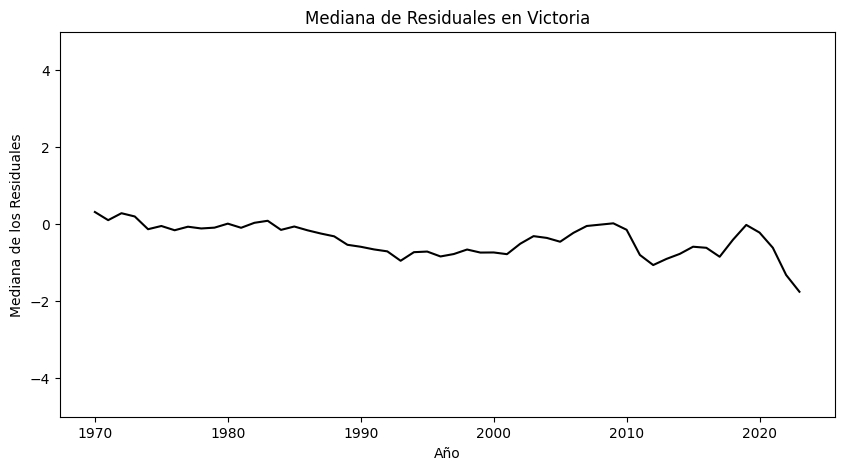

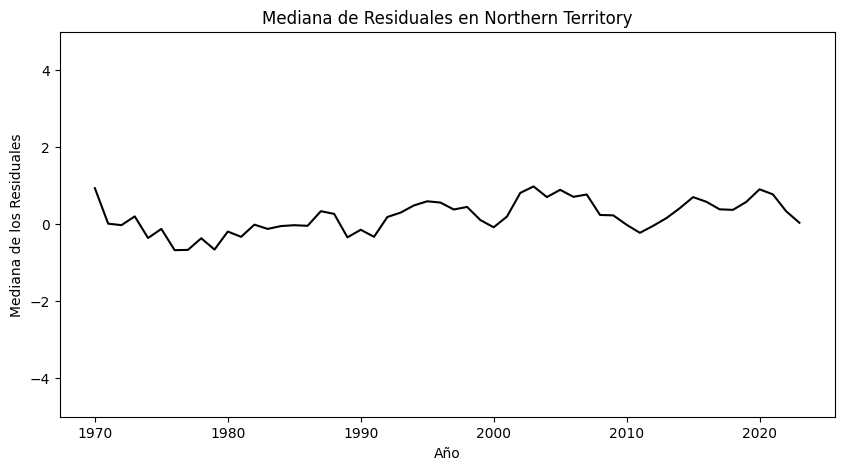

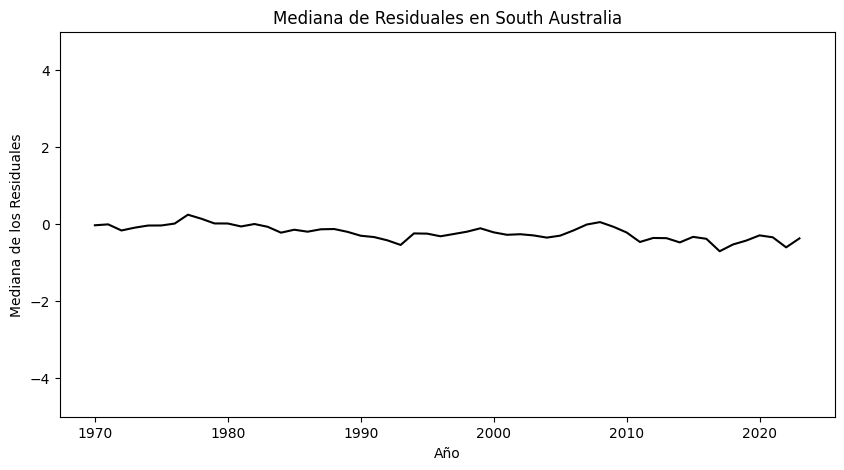

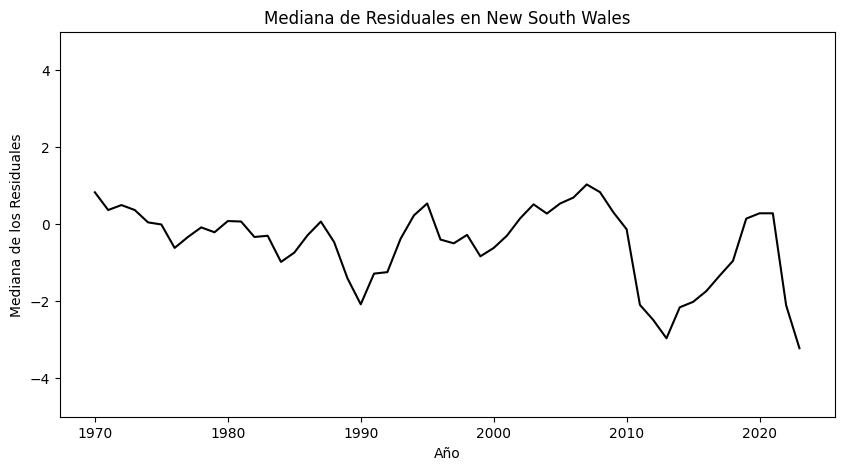

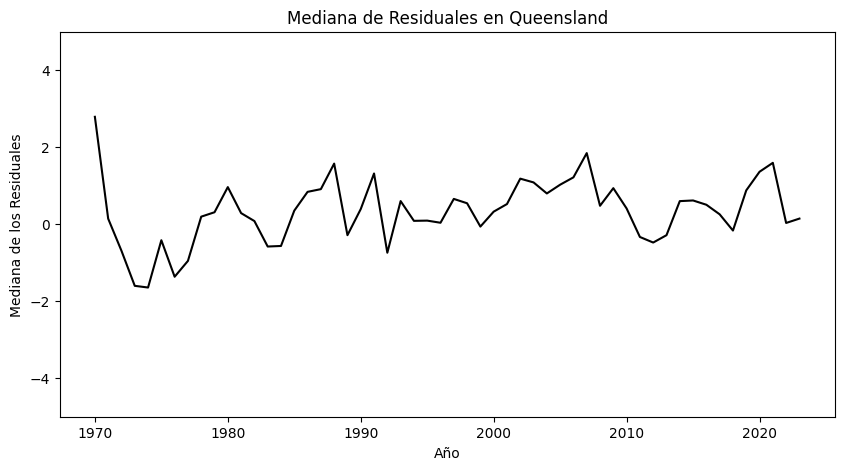

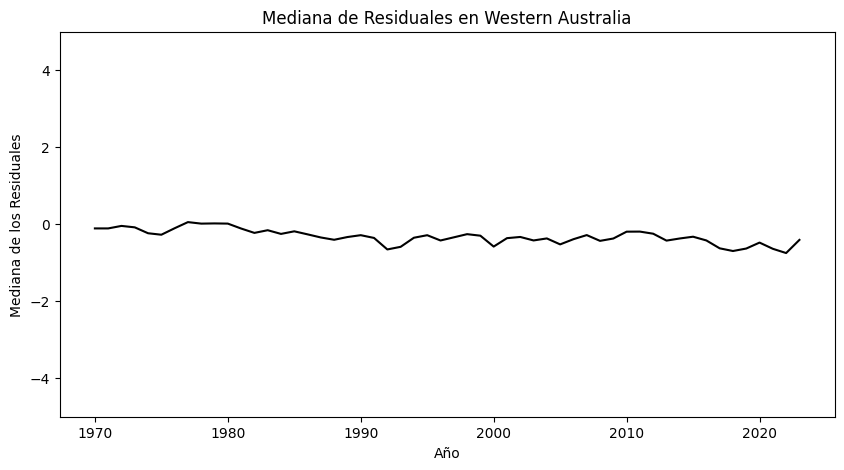

In [12]:
output_folder = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\residuales\regiones'
os.makedirs(output_folder, exist_ok=True)  # Crear la carpeta si no existe

for region, valores in residuales_por_region.items():
    valores_median = np.nanmedian(valores, axis=1)  # Tomar la mediana a lo largo de las estaciones
    
    plt.figure(figsize=(10, 5))
    plt.plot(t_all + 1970, valores_median, 'k-')  # Línea negra

    plt.xlabel("Año")
    plt.ylabel("Mediana de los Residuales")
    plt.title(f"Mediana de Residuales en {region}")
    plt.ylim(-5, 5)
    
    # Definir la ruta del archivo
    filename = os.path.join(output_folder, f"residuales_{region.replace(' ', '_')}.png")
    
    # Guardar la imagen
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

#### Residuales: cuencas hidrogeológicas

In [16]:
shp_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\australia_aquifers.shp'
cuencas = gpd.read_file(shp_path)

In [17]:
lat = np.array(lat).ravel()  # Asegurar que sea 1D
lon = np.array(lon).ravel()  # Asegurar que sea 1D

In [18]:
gdf_stations = gpd.GeoDataFrame(pd.DataFrame({'lat': lat, 'lon': lon}), 
                                geometry=gpd.points_from_xy(lon, lat),
                                crs="EPSG:4326")  # Coordenadas geográficas

# Asegurar que las cuencas tengan el mismo sistema de referencia
cuencas = cuencas.to_crs(gdf_stations.crs)

# Realizar la unión espacial para asignar la cuenca a cada estación
gdf_stations = gdf_stations.sjoin(cuencas[['geometry', 'Broader']], how='left')

# Revisar los resultados
print(gdf_stations[['lat', 'lon', 'Broader']].head())

         lat         lon               Broader
0 -33.437086  148.222974                     -
1 -30.094821  149.562252  Great Artesian Basin
2 -31.519814  150.652527                     -
3 -34.479717  144.299661          Murray Basin
4 -35.955811  145.964653          Murray Basin


In [19]:
# Usar listas para acumular valores antes de convertir a matriz
residuales_por_cuenca = defaultdict(list)

# Encontrar la longitud máxima de todas las series (para padding con NaN)
max_length = len(t_all)

for i in range(ndat):
    if condyr[i] == 0:
        continue

    cuenca = gdf_stations.loc[i, 'Broader']  # Obtener la cuenca de la estación

    if pd.notna(cuenca):  # Solo considerar estaciones con cuenca asignada
        i0, i1 = s_nmax_yr[i], s_nmax_yr[i] + nmax_yr[i]

        if i1 > max_length:  # Asegurar que no exceda el índice
            i1 = max_length

        res = vyr[i, i0:i1] - (t_all[i0:i1] * slop_t[i] + interc_t[i])
        res = np.nan_to_num(res)  # Convertir NaN a 0 para evitar propagación

        # Crear un array de NaN con el tamaño máximo
        res_padded = np.full(max_length, np.nan)
        res_padded[i0:i1] = res  # Insertar los valores en el rango correcto

        # Agregar la serie de residuales a la lista de la cuenca
        residuales_por_cuenca[cuenca].append(res_padded)

# Convertir listas en matrices 2D asegurando que las dimensiones coincidan
for cuenca in residuales_por_cuenca:
    residuales_por_cuenca[cuenca] = np.array(residuales_por_cuenca[cuenca]).T  # Transponer para (tiempo, estaciones)

In [20]:
output_folder = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\residuales\cuencas'
os.makedirs(output_folder, exist_ok=True)  # Crear la carpeta si no existe

for cuenca, valores in residuales_por_cuenca.items():
    valores_median = np.nanmedian(valores, axis=1)  # Tomar la mediana a lo largo de las estaciones
    
    plt.figure(figsize=(10, 5))
    plt.plot(t_all + 1970, valores_median, 'k-')  # Línea negra

    plt.xlabel("Año")
    #plt.ylabel("Mediana de los Residuales")
    #plt.title(f"Mediana de Residuales en {cuenca}")
    plt.ylim(-10, 10)
    
    # Definir la ruta del archivo
    filename = os.path.join(output_folder, f"residuales_{cuenca.replace(' ', '_')}.png")
    
    # Guardar la imagen
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()  # Cerrar la figura para liberar memoria

C:\Users\Andrea Fandiño P\AppData\Local\Temp\ipykernel_18804\1587189917.py:5: RuntimeWarning: All-NaN slice encountered
  valores_median = np.nanmedian(valores, axis=1)  # Tomar la mediana a lo largo de las estaciones


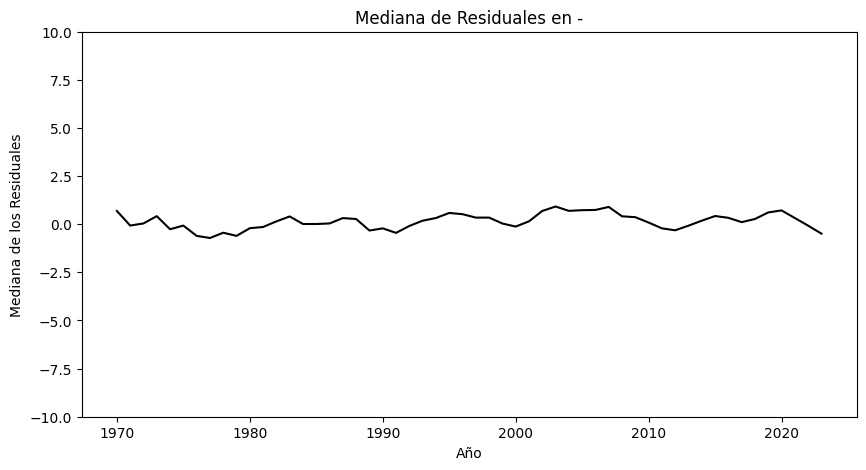

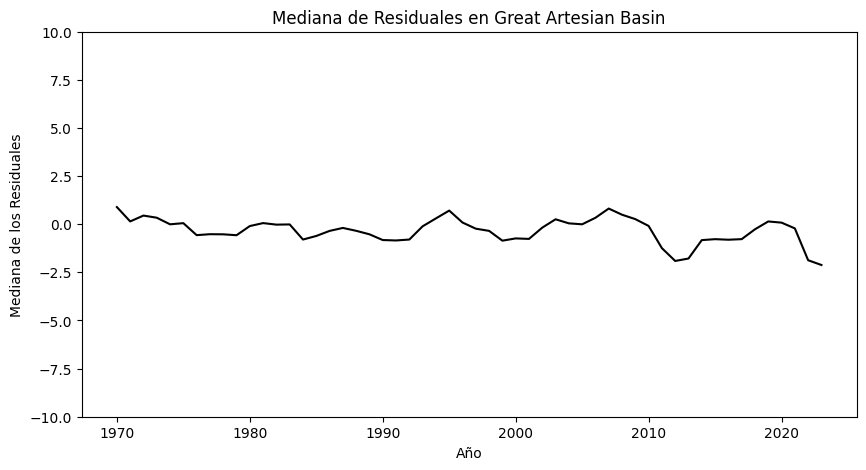

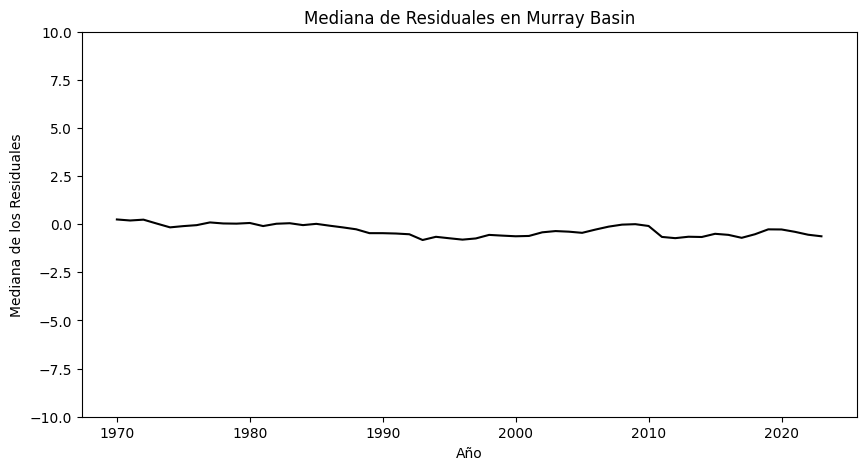

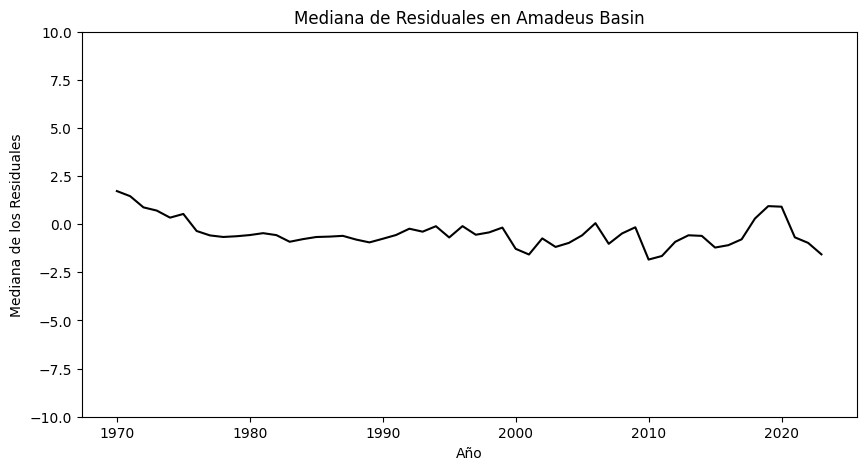

C:\Users\Andrea Fandiño P\AppData\Local\Temp\ipykernel_18804\1229264665.py:2: RuntimeWarning: All-NaN slice encountered
  valores_median = np.nanmedian(valores, axis=1)  # Tomar la mediana a lo largo de las estaciones


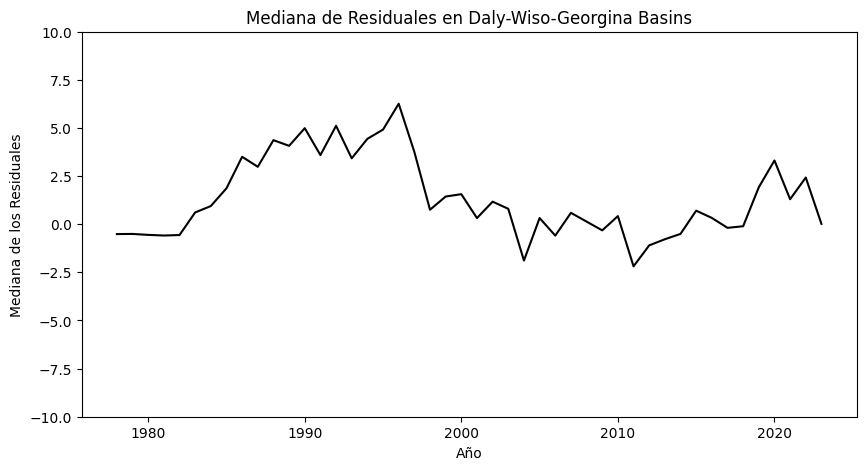

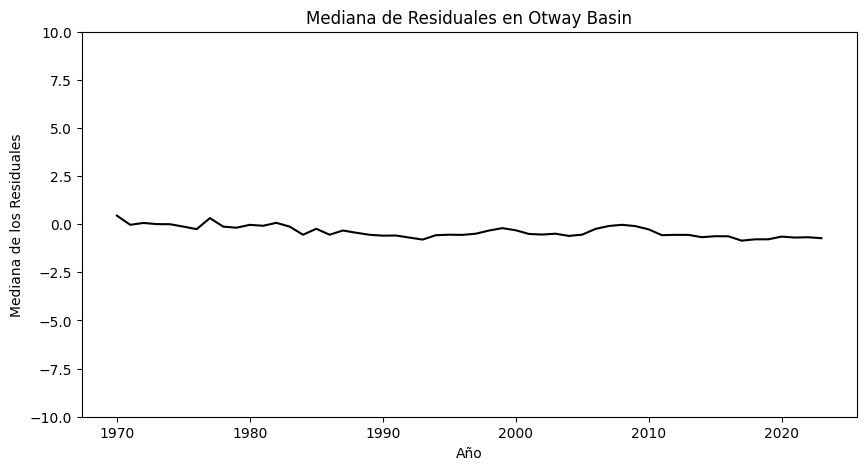

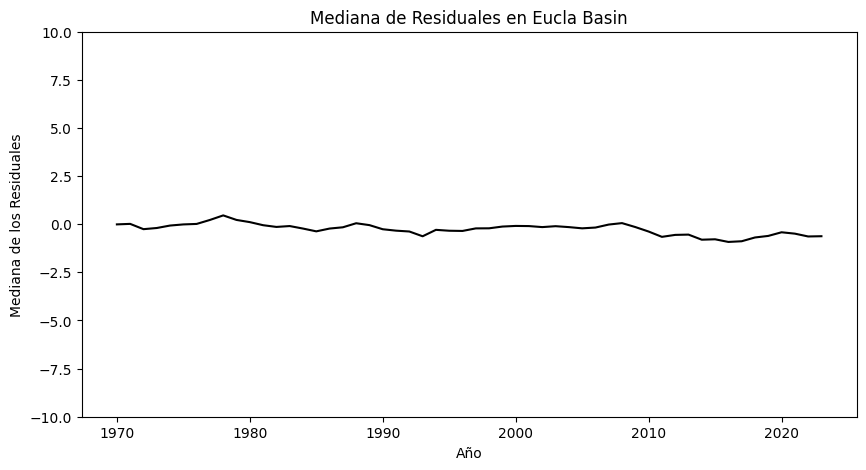

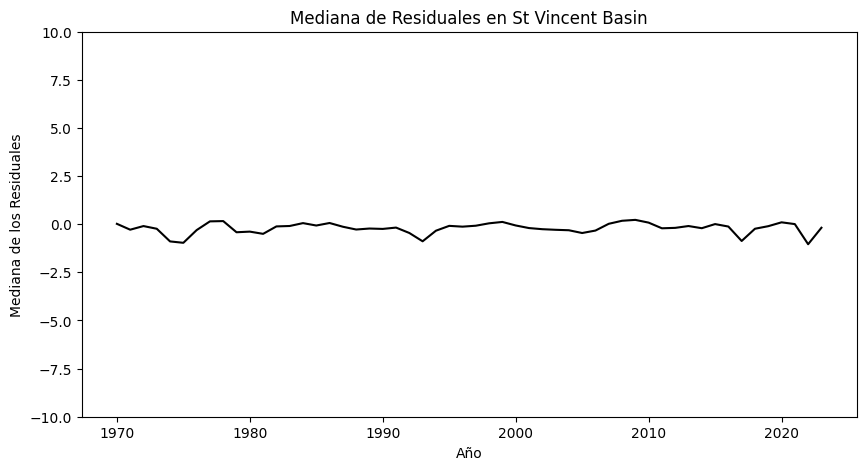

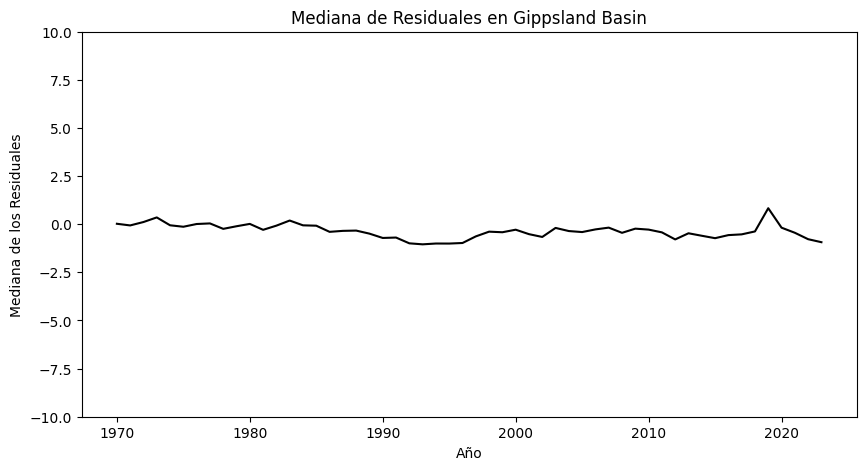

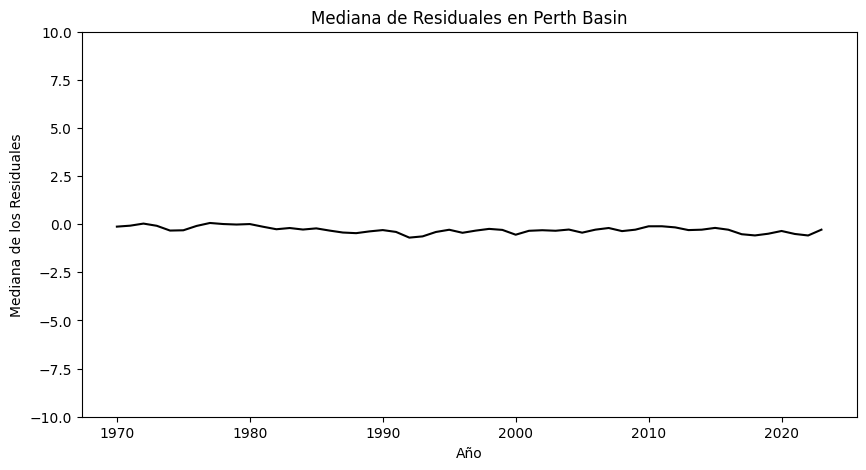

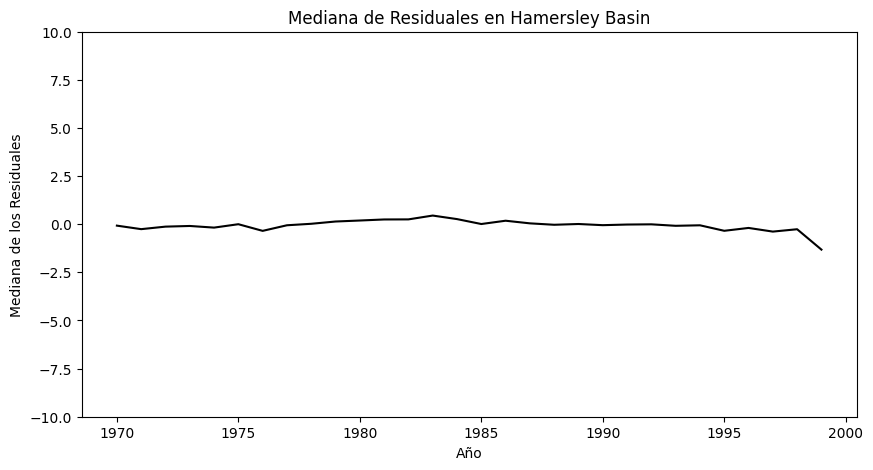

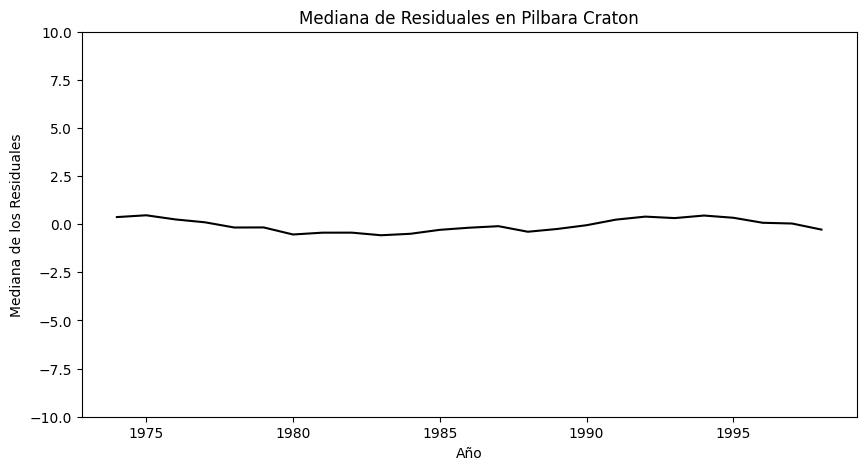

In [21]:
for cuenca, valores in residuales_por_cuenca.items():
    valores_median = np.nanmedian(valores, axis=1)  # Tomar la mediana a lo largo de las estaciones
    
    plt.figure(figsize=(10, 5))
    plt.plot(t_all + 1970, valores_median, 'k-')  # Línea negra

    plt.xlabel("Año")
    plt.ylabel("Mediana de los Residuales")
    plt.title(f"Mediana de Residuales en {cuenca}")
    plt.ylim(-10, 10)
    
    plt.show()